In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
import itertools
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
import scipy
from scipy import spatial
from scipy import stats

from mutspec_utils.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from mutspec_utils.constants import possible_codons, possible_sbs12, possible_sbs192
from mutspec_utils.io import read_genbank_ref
from mutspec_utils.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk

sns.set_style()

## Read data

### Verterbata

In [2]:
path_to_data = "../data/MutSpecVertebratescytb.csv"
mutspec = pd.read_csv(path_to_data)
print(mutspec.shape, mutspec.shape[0] / 192)
mutspec.head()

(187008, 10) 974.0


,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


### Cancer

In [3]:
cancer_ms = pd.read_csv("../data/external/cancer_mutspec.csv")[["Mut", "MutSpec_ExDloop"]].rename(columns={"MutSpec_ExDloop": "MutSpec"})
cancer_ms

,Mut,MutSpec
0,A[A>C]A,0.000000
1,A[A>C]C,0.000783
2,A[A>C]G,0.000000
3,A[A>C]T,0.000084
4,A[A>G]A,0.008273
...,...,...
187,T[T>C]T,0.000471
188,T[T>G]A,0.000133
189,T[T>G]C,0.000000
190,T[T>G]G,0.001074


## Number of observed mutations

In [4]:
mutspec["IsObserved"] = mutspec["Observed"] > 0
mutspec.head(2)

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class,IsObserved
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii,False
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii,False


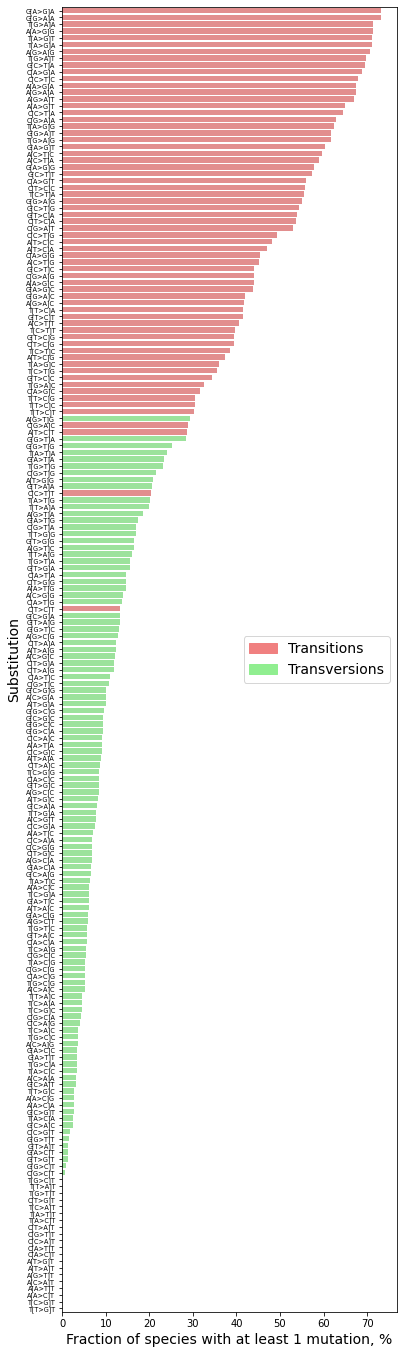

In [21]:
mcounts = mutspec.groupby("Mut").IsObserved.value_counts().rename("Count").reset_index().pivot('Mut','IsObserved', "Count").fillna(0).sort_values(False)
mcounts[False] = mcounts[False].astype("int")
mcounts[True] = mcounts[True].astype("int")
mcounts.columns.name = None
mcounts["Abundance"] = mcounts[True] / (mcounts[True] + mcounts[False]) * 100


clr1 = "lightcoral"
clr2 = "lightgreen"
mcounts["Color"] = [clr1 if x[2:5] in ['A>G', 'C>T', 'G>A', 'T>C'] else clr2 for x in mcounts.index.values]


patch1 = mpatches.Patch(color=clr1, label='Transitions')
patch2 = mpatches.Patch(color=clr2, label='Transversions')

plt.figure(figsize=(6, 24))
ax = sns.barplot(data=mcounts, y=mcounts.index, x="Abundance", 
            palette=mcounts.Color,
)
plt.yticks(rotation=0, fontsize=6.5)
plt.xlabel("Fraction of species with at least 1 mutation, %", fontsize=14)
plt.ylabel("Substitution", fontsize=14)
ax.legend(loc='center right', handles=[patch1, patch2], fontsize=14)
plt.savefig("../ToPaper/SupplementaryFigure3.pdf", bbox_inches='tight')
plt.show()

Text(381.25000000000006, 0.5, '')

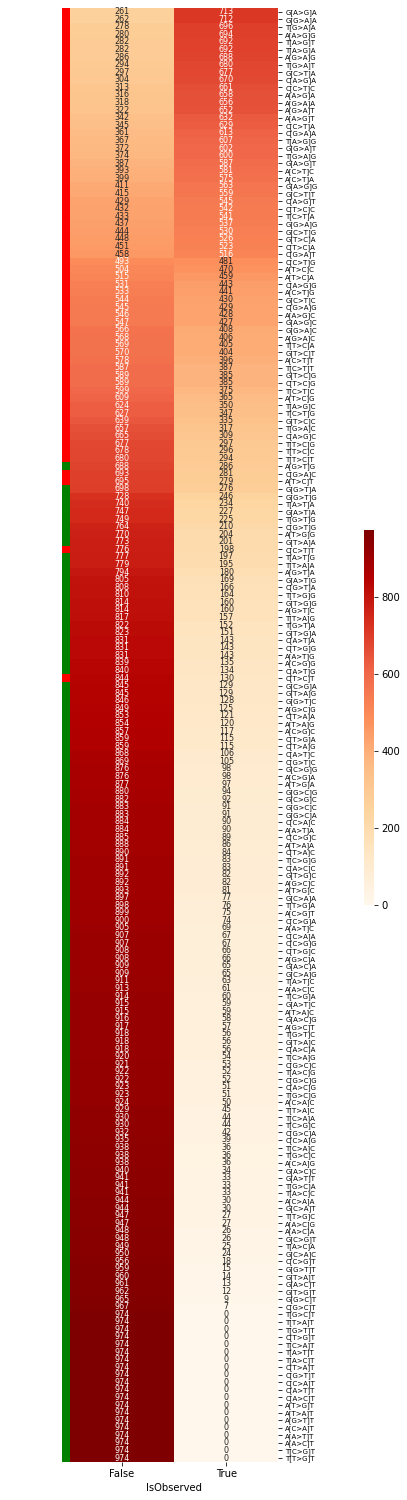

In [85]:
mcounts = mutspec.groupby("Mut").IsObserved.value_counts().rename("Count").reset_index().pivot('Mut','IsObserved', "Count").fillna(0).sort_values(False)
mcounts[False] = mcounts[False].astype("int")
mcounts[True] = mcounts[True].astype("int")

grd = sns.clustermap(
    data=mcounts,
    cmap="OrRd",
    figsize=(5, 26),
    col_cluster=False, row_cluster=False,
    cbar_pos=(1.02, .32, .03, .2),
    yticklabels=mcounts.index,
    annot=True,
    fmt=".0f",
    annot_kws={'fontsize': 8},
    row_colors=pd.Series(mcounts.index).apply(lambda x: "red" if x[2:5] in ['A>G', 'C>T', 'G>A', 'T>C'] else "green").values
)
plt.setp(grd.ax_heatmap.get_yticklabels(), size=7,)
grd.ax_col_dendrogram.remove()
grd.ax_heatmap.set_ylabel("")
# grd.ax_heatmap.set_xlabel("Number of species")
# grd.savefig("../pictures/sbs_counts.pdf")

## Complementary sbs

In [5]:
mutspec["sbs96"] = mutspec["Mut"].apply(lambda sbs: sbs if sbs[2:5] in {"C>A", "C>G", "C>T", "T>A", "T>C", "T>G"} else rev_comp(sbs))
mutspec["is_cosmic"] = mutspec["Mut"].apply(lambda sbs: sbs[2:5] in {"C>A", "C>G", "C>T", "T>A", "T>C", "T>G"})

In [6]:
mutspec

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class,sbs96,is_cosmic
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,TTT,Actinopterygii,T[T>G]T,True
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,GTT,Actinopterygii,G[T>G]T,True
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,CTT,Actinopterygii,C[T>G]T,True
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.000000,T>G,ATT,Actinopterygii,A[T>G]T,True
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.000000,T>C,TTT,Actinopterygii,T[T>C]T,True
...,...,...,...,...,...,...,...,...,...,...,...,...
187003,Zosterops_japonicus,A[A>G]A,3.0,3.0,1.0,15.981840,0.062571,A>G,AAA,Aves,T[T>C]T,False
187004,Zosterops_japonicus,T[A>C]A,1.0,0.0,0.0,15.981840,0.000000,A>C,TAA,Aves,T[T>G]A,False
187005,Zosterops_japonicus,G[A>C]A,5.0,0.0,0.0,15.981840,0.000000,A>C,GAA,Aves,T[T>G]C,False
187006,Zosterops_japonicus,C[A>C]A,4.0,0.0,0.0,15.981840,0.000000,A>C,CAA,Aves,T[T>G]G,False


In [7]:
_d = pd.DataFrame({"sbs96": mutspec["sbs96"].unique()})
_d["sbs6"] = _d["sbs96"].apply(lambda x: x[2:5])
_d = _d.sort_values("sbs6")
_d

,sbs96,sbs6
53,C[C>A]G,C>A
51,C[C>A]A,C>A
15,A[C>A]T,C>A
14,A[C>A]G,C>A
13,A[C>A]C,C>A
...,...,...
73,G[T>G]C,T>G
72,T[T>G]C,T>G
71,C[T>G]C,T>G
39,A[T>G]A,T>G


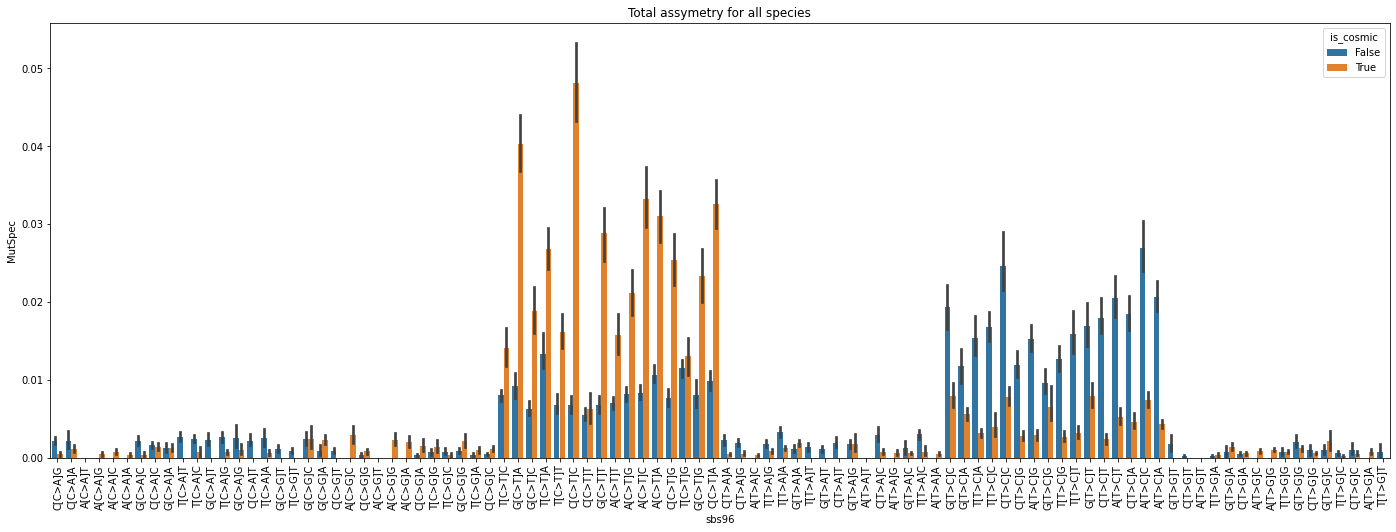

In [9]:
plt.figure(figsize=(24, 8))
sns.barplot(data=mutspec, x="sbs96", y="MutSpec", hue="is_cosmic", order=_d.sbs96.values)
plt.xticks(rotation=90)
plt.title("Total assymetry for all species")
plt.savefig("../pictures/sbs_assymetry_barplot.pdf")
plt.show()

In [12]:
mutspec[(mutspec.Species == "Abbottina_obtusirostris") & (mutspec.sbs96 == "T[T>G]T")]

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class,sbs96,is_cosmic
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii,T[T>G]T,True
191,Abbottina_obtusirostris,A[A>C]A,2.0,0.0,0.0,1.088889,0.0,A>C,AAA,Actinopterygii,T[T>G]T,False


In [61]:
_p = mutspec.pivot(["Species", "sbs96"], "is_cosmic", "MutSpec").reset_index()
_p["ratio"] = _p[True] / _p[False]
# _p["ratio"] = _p[False] / _p[True]
_p["ratio"] = _p["ratio"].replace(np.inf, np.nan)
_p

is_cosmic,Species,sbs96,False,True,ratio
0,Abbottina_obtusirostris,A[C>A]A,0.000000,0.0,NaN
1,Abbottina_obtusirostris,A[C>A]C,0.000000,0.0,NaN
2,Abbottina_obtusirostris,A[C>A]G,0.000000,0.0,NaN
3,Abbottina_obtusirostris,A[C>A]T,0.000000,0.0,NaN
4,Abbottina_obtusirostris,A[C>G]A,0.000000,0.0,NaN
...,...,...,...,...,...
93499,Zosterops_japonicus,T[T>C]T,0.062571,0.0,0.0
93500,Zosterops_japonicus,T[T>G]A,0.000000,0.0,NaN
93501,Zosterops_japonicus,T[T>G]C,0.000000,0.0,NaN
93502,Zosterops_japonicus,T[T>G]G,0.000000,0.0,NaN


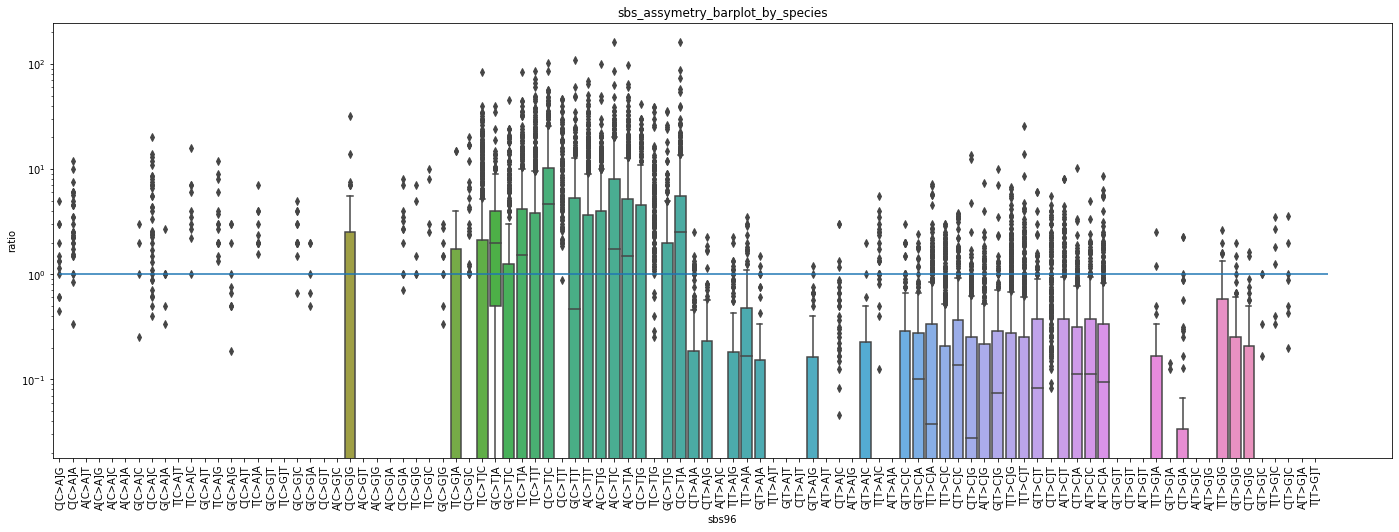

In [62]:
plt.figure(figsize=(24, 8))
sns.boxplot(data=_p, x="sbs96", y="ratio", order=_d.sbs96.values)
plt.xticks(rotation=90)
plt.title("sbs_assymetry_barplot_by_species")
plt.yscale("log")
plt.hlines([1], 0, 96)
plt.savefig("../pictures/sbs_assymetry_barplot_by_species.pdf")
plt.show()

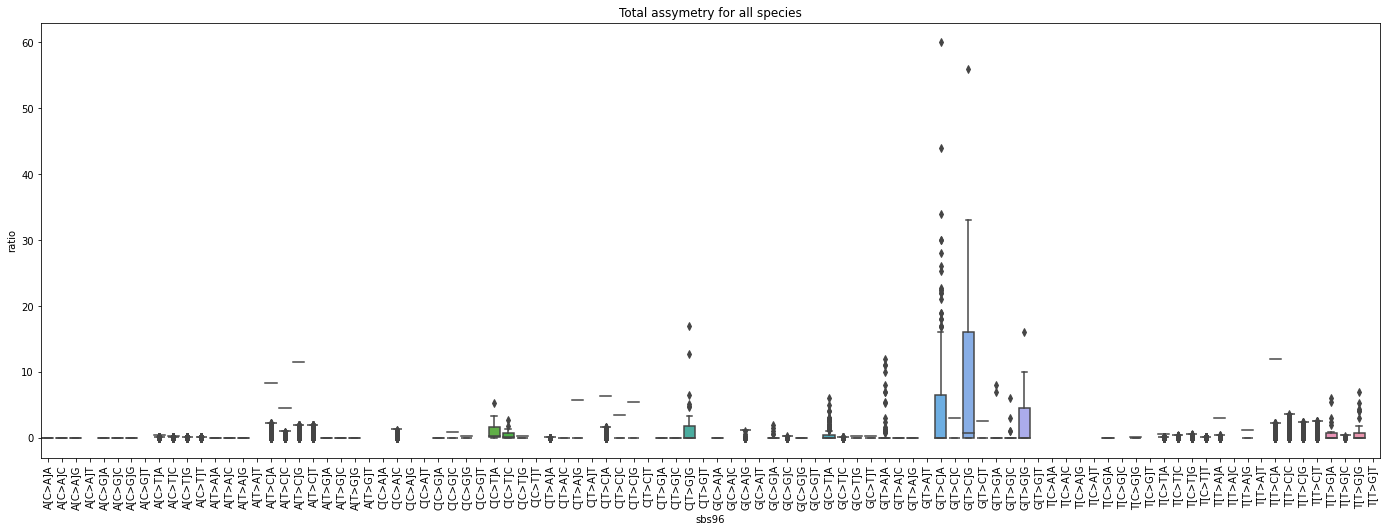

In [41]:
plt.figure(figsize=(24, 8))
sns.boxplot(data=_p, x="sbs96", y="ratio", )
plt.xticks(rotation=90)
plt.title("Total assymetry for all species")
# plt.savefig("../pictures/sbs_assymetry_barplot.pdf")
plt.show()

## LOO

In [6]:
def get_class_mutspec(df: Union[pd.DataFrame, str]):
    if isinstance(df, str) and df == "cancer":
        return cancer_ms
    ms = df.groupby("Mut")["RawMutSpec"].sum().reset_index().rename(columns={"RawMutSpec": "MutSpec"})
    ms["MutSpec"] = (ms["MutSpec"] / ms["MutSpec"].sum()).fillna(0)
    return ms


def sample_sp_ms(df: pd.DataFrame, ntimes=100):
    sp = df.Species.unique()
    df = df.set_index("Species")
    n = len(sp)
    for _ in range(ntimes):
        smpl = np.random.choice(sp, n)
        mut = df.loc[smpl]
        yield mut


def dummy_sampler(ntimes=100):
    for _ in range(ntimes):
        yield "cancer"

In [ ]:
classes = list(mutspec["Class"].unique()) + ["cancer"]
ntimes = 100
data = []
for cls1, cls2 in itertools.combinations(classes, 2):
    if cls1 == "cancer":
        muts1 = dummy_sampler(ntimes)
    else:
        muts1 = sample_sp_ms(mutspec[(mutspec.Class == cls1)], ntimes)

    if cls2 == "cancer":
        muts2 = dummy_sampler(ntimes)
    else:
        muts2 = sample_sp_ms(mutspec[(mutspec.Class == cls2)], ntimes)
        
    for i in range(ntimes):
        gr1, gr2 = next(muts1), next(muts2)
        ms1, ms2 = get_class_mutspec(gr1), get_class_mutspec(gr2)
        sim = 1 - spatial.distance.cosine(ms1.sort_values("Mut").MutSpec.values, ms2.sort_values("Mut").MutSpec.values)
        data.append({
            "cls1": cls1,
            "cls2": cls2,
            "DroppedSBS": "none",
            "CosSim": sim,
        })
        for sbs_to_drop in mutspec.Mut.unique():
            ms1drp, ms2drp = ms1[ms1.Mut != sbs_to_drop], ms2[ms2.Mut != sbs_to_drop]
            sim = 1 - spatial.distance.cosine(ms1drp.sort_values("Mut").MutSpec.values, ms2drp.sort_values("Mut").MutSpec.values)
            data.append({
                "cls1": cls1,
                "cls2": cls2,
                "DroppedSBS": sbs_to_drop,
                "CosSim": sim,
            })

In [20]:
# dif = pd.DataFrame(data)
# dif.to_csv("../data/dif.csv", index=None)

dif = pd.read_csv("../data/dif.csv")
dif

,cls1,cls2,DroppedSBS,CosSim
0,Actinopterygii,Mammalia,none,0.935247
1,Actinopterygii,Mammalia,T[T>G]T,0.935247
2,Actinopterygii,Mammalia,G[T>G]T,0.935247
3,Actinopterygii,Mammalia,C[T>G]T,0.935247
4,Actinopterygii,Mammalia,A[T>G]T,0.935247
...,...,...,...,...
289495,Amphibia,cancer,A[A>G]A,0.774055
289496,Amphibia,cancer,T[A>C]A,0.774105
289497,Amphibia,cancer,G[A>C]A,0.774103
289498,Amphibia,cancer,C[A>C]A,0.774141


In [138]:
i = 0
for l, gr in dif.groupby(["cls1", "cls2"]):
    i += 1
i

15

In [155]:
gr

,cls1,cls2,DroppedSBS,CosSim
154400,Mammalia,cancer,none,0.788018
154401,Mammalia,cancer,T[T>G]T,0.788018
154402,Mammalia,cancer,G[T>G]T,0.788026
154403,Mammalia,cancer,C[T>G]T,0.788018
154404,Mammalia,cancer,A[T>G]T,0.788018
...,...,...,...,...
173695,Mammalia,cancer,A[A>G]A,0.777184
173696,Mammalia,cancer,T[A>C]A,0.776485
173697,Mammalia,cancer,G[A>C]A,0.776498
173698,Mammalia,cancer,C[A>C]A,0.776480


In [188]:
def filter_similar(gr: pd.DataFrame, pcutoff=0.05):
    ref = gr[gr.DroppedSBS == "none"].CosSim.values
    used_sbs = []
    for sbs in possible_sbs192:
        sample = gr[gr.DroppedSBS == sbs].CosSim.values
        t, pval = stats.ttest_ind(ref, sample)
        if pval <= pcutoff:  # TODO ADJUST MULTIPLE COMPARIONS
            used_sbs.append(sbs)
    if len(used_sbs):
        used_sbs.append("none")
    print(gr.iloc[0, :2].values, "\t\t", used_sbs)
    return gr[gr.DroppedSBS.isin(used_sbs)]


# def filter_similar(gr: pd.DataFrame, p=0.3):
#     me = gr.groupby("DroppedSBS").CosSim.mean()
#     ref = me.loc["none"]
#     dif = (me - ref).abs()
#     used_sbs = list(dif[dif > (dif.max() * p)].index) + ["none"]
#     return gr[gr.DroppedSBS.isin(used_sbs)]

In [189]:
filtered = dif.groupby(["cls1", "cls2"]).apply(filter_similar).reset_index(drop=True)
filtered["lbl"] = filtered.cls1 + "-" + filtered.cls2
filtered

['Actinopterygii' 'Amphibia'] 		 []
['Actinopterygii' 'Aves'] 		 ['A[A>G]A', 'A[C>T]G', 'C[C>T]C', 'C[C>T]G', 'G[C>T]A', 'none']
['Actinopterygii' 'Lepidosauria'] 		 ['A[C>T]A', 'C[C>T]C', 'C[C>T]G', 'T[C>T]A', 'T[C>T]T', 'none']
['Actinopterygii' 'Mammalia'] 		 ['A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'C[C>T]A', 'C[C>T]C', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'T[C>T]A', 'T[C>T]G', 'T[C>T]T', 'none']
['Actinopterygii' 'cancer'] 		 ['A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'none']
['Amphibia' 'cancer'] 		 ['A[C>T]A', 'A[C>T]G', 'A[C>T]T', 'T[C>T]A', 'T[C>T]G', 'none']
['Aves' 'Amphibia'] 		 ['A[A>G]A', 'A[C>T]G', 'C[C>T]C', 'none']
['Aves' 'Lepidosauria'] 		 ['A[A>G]A', 'C[C>T]C', 'G[C>T]G', 'G[C>T]T', 'none']
['Aves' 'cancer'] 		 ['A[A>G]A', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'C[C>T]C', 'G[C>T]A', 'G[C>T]G', 'G[C>T]T', 'T[C>T]G', 'none']
['Lepidosauria' 'Amphibia'] 		 ['C[C>T]C', 'G[C>T]A', 'T[C>T]A', 'none']
['Lepidosa

,cls1,cls2,DroppedSBS,CosSim,lbl
0,Actinopterygii,Aves,none,0.858722,Actinopterygii-Aves
1,Actinopterygii,Aves,C[C>T]G,0.870563,Actinopterygii-Aves
2,Actinopterygii,Aves,A[C>T]G,0.865693,Actinopterygii-Aves
3,Actinopterygii,Aves,C[C>T]C,0.843539,Actinopterygii-Aves
4,Actinopterygii,Aves,G[C>T]A,0.847970,Actinopterygii-Aves
...,...,...,...,...,...
10095,Mammalia,cancer,C[C>T]C,0.762580,Mammalia-cancer
10096,Mammalia,cancer,A[C>T]C,0.762854,Mammalia-cancer
10097,Mammalia,cancer,G[A>G]C,0.771475,Mammalia-cancer
10098,Mammalia,cancer,G[C>T]A,0.773032,Mammalia-cancer


In [190]:
filtered.DroppedSBS.nunique(), filtered.DroppedSBS.unique()

(20,
 array(['none', 'C[C>T]G', 'A[C>T]G', 'C[C>T]C', 'G[C>T]A', 'A[A>G]A',
        'T[C>T]T', 'T[C>T]A', 'A[C>T]A', 'T[C>T]G', 'G[C>T]G', 'G[C>T]C',
        'A[C>T]C', 'C[C>T]A', 'C[C>T]T', 'T[C>T]C', 'A[C>T]T', 'G[C>T]T',
        'G[A>G]C', 'G[A>G]G'], dtype=object))

In [191]:
colored_sbs = {sbs: clr for sbs, clr in zip(filtered.DroppedSBS.unique(), np.random.choice(list(matplotlib.colors.cnames.keys()), filtered.DroppedSBS.nunique()))}

In [196]:
colored_sbs

{'none': 'lightgray',
 'C[C>T]G': 'mediumslateblue',
 'A[C>T]G': 'skyblue',
 'C[C>T]C': 'black',
 'G[C>T]A': 'lightsteelblue',
 'A[A>G]A': 'darkmagenta',
 'T[C>T]T': 'chocolate',
 'T[C>T]A': 'tomato',
 'A[C>T]A': 'yellow',
 'T[C>T]G': 'mediumslateblue',
 'G[C>T]G': 'papayawhip',
 'G[C>T]C': 'orangered',
 'A[C>T]C': 'blanchedalmond',
 'C[C>T]A': 'lawngreen',
 'C[C>T]T': 'aquamarine',
 'T[C>T]C': 'navy',
 'A[C>T]T': 'lemonchiffon',
 'G[C>T]T': 'yellow',
 'G[A>G]C': 'darkslategray',
 'G[A>G]G': 'orange'}

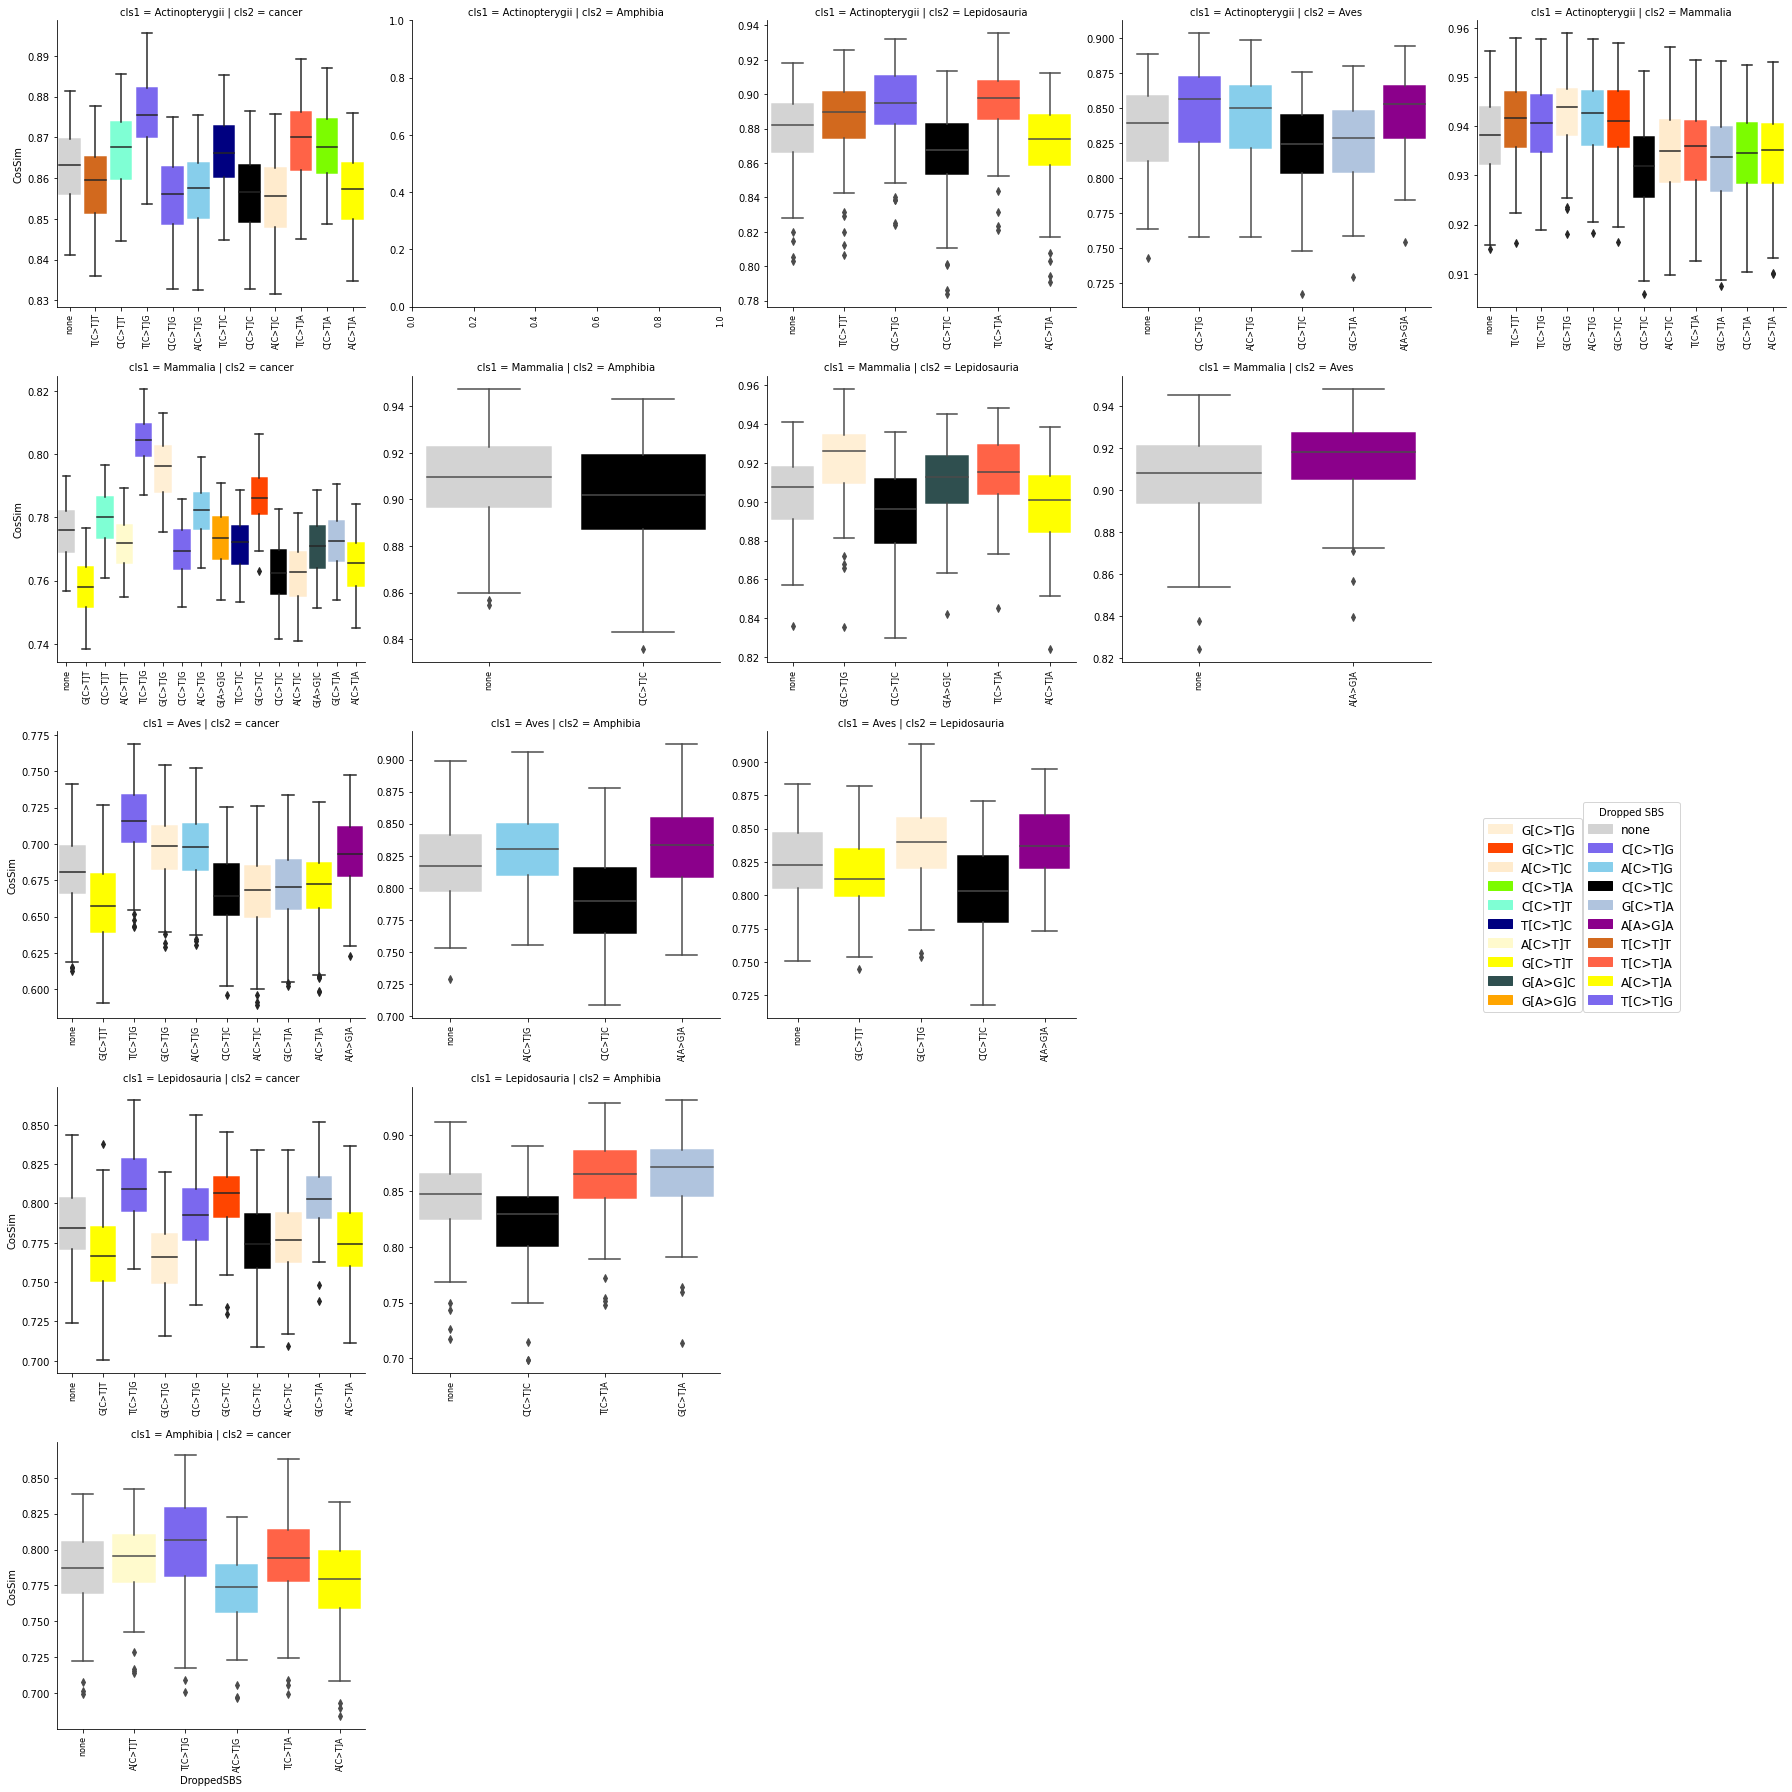

In [195]:
colors = ["aqua", "red", "darkorchid", "steelblue", "tan", "steelblue", "teal"]

g = sns.FacetGrid(
    filtered, col="cls2", row="cls1", sharey=False, sharex=False, 
    col_order=['cancer', 'Amphibia', 'Lepidosauria', 'Aves', 'Mammalia',],
    row_order=['Actinopterygii', 'Mammalia', 'Aves', 'Lepidosauria', "Amphibia"],
    size=5, 
)
g.map(sns.boxplot, "DroppedSBS", "CosSim", palette=colors)
g.set_xticklabels(rotation=90, fontsize=8)

empty_axes = [
    ("Lepidosauria", "Mammalia"), ("Mammalia", "Mammalia"), ("Lepidosauria", "Aves"), 
    ("Lepidosauria", "Lepidosauria"), ("Aves", "Aves"), 
    ("Amphibia", "Amphibia"), ("Amphibia", "Aves"), ("Amphibia", "Lepidosauria"), ("Amphibia", "Mammalia"),
    ("Aves", "Mammalia"),
]
for cls_lbl, ax in g.axes_dict.items():
    if cls_lbl == empty_axes[-1]:
        ax.set_title("")
        ax.set_axis_off()
        patches = [mpatches.Patch(color=clr, label=sbs) for sbs, clr in colored_sbs.items()]
        first_legend = ax.legend(title="Dropped SBS", handles=patches[:len(patches)//2], fontsize=12, loc='lower center')
        ax.add_artist(first_legend)
        ax.legend(handles=patches[len(patches)//2:], fontsize=12, loc='lower left')
    elif cls_lbl in empty_axes:
        ax.remove()
    else:
        for bar, tick in zip(ax.patches, ax.get_xticklabels()):
            sbs = tick.get_text()
            bar.set_color(colored_sbs[sbs])

g.fig.tight_layout()
g.savefig("../pictures/valuable_substitutions_LOO.pdf")
plt.show()

## raw barplots

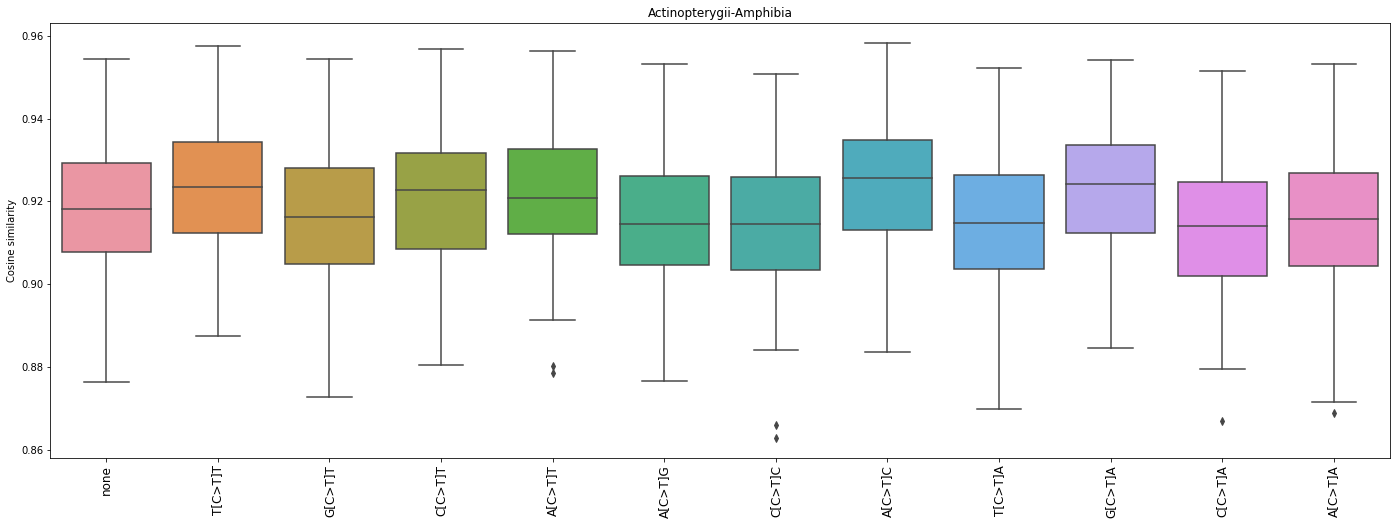

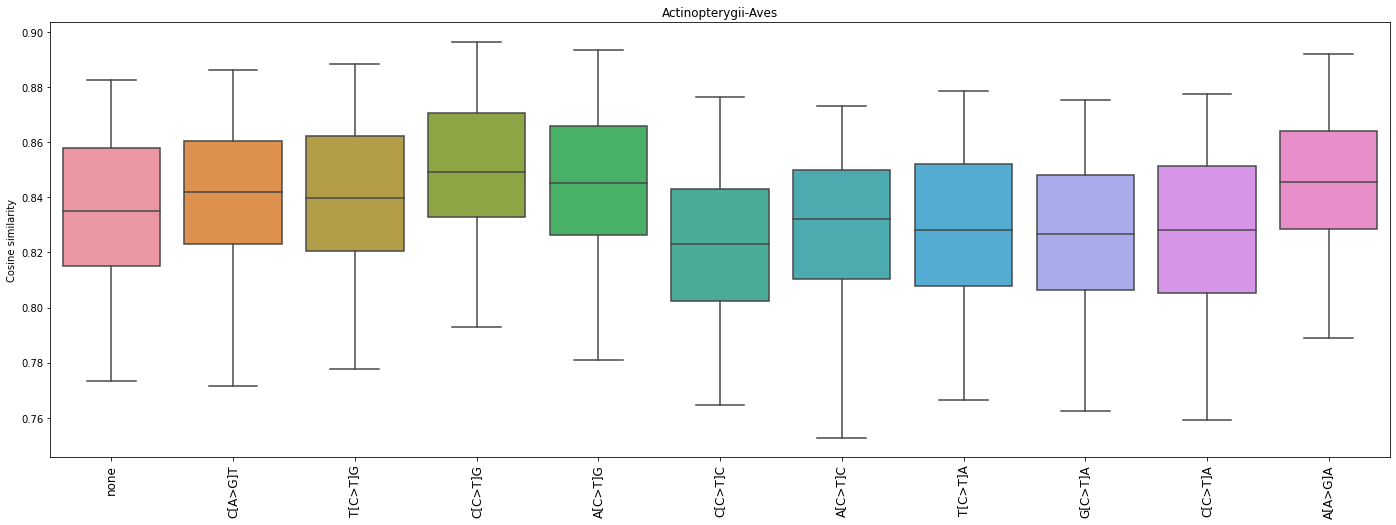

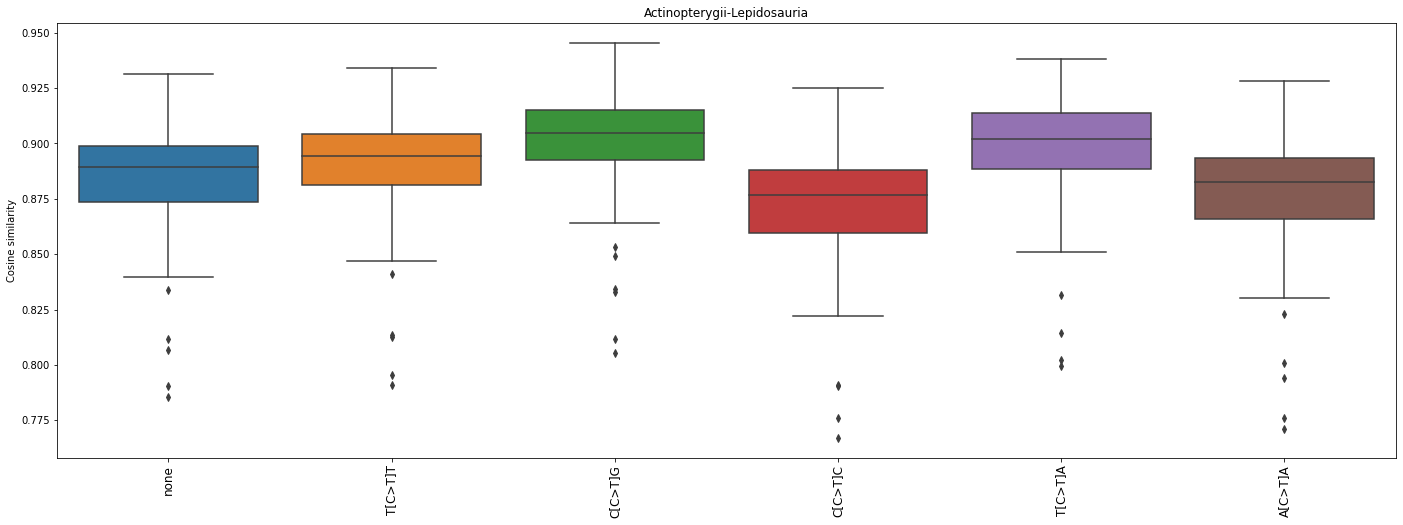

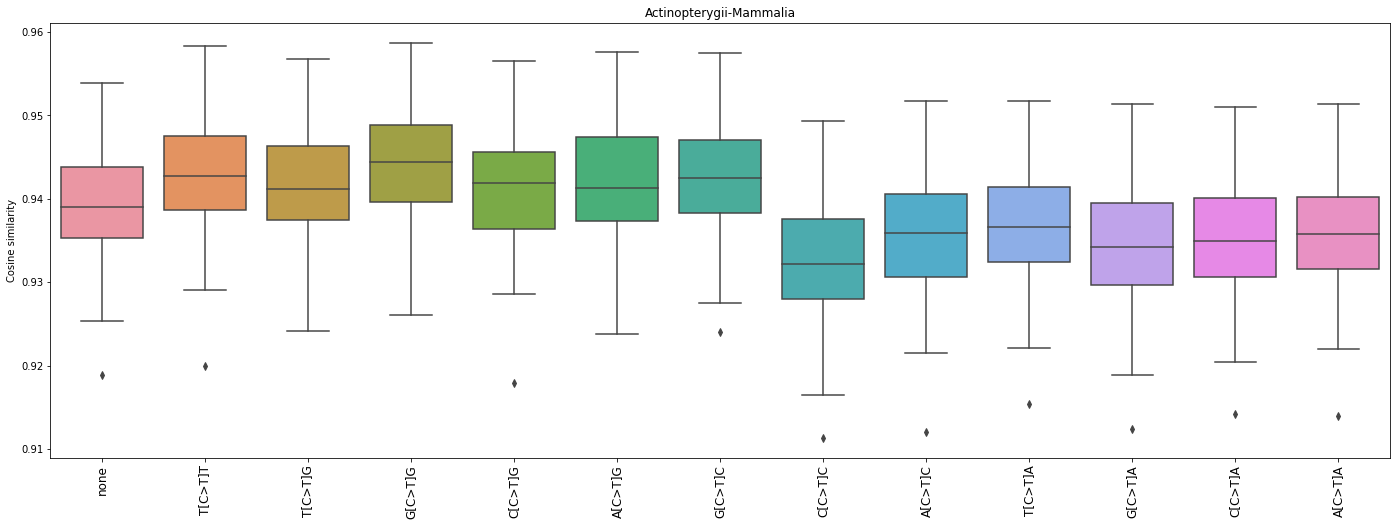

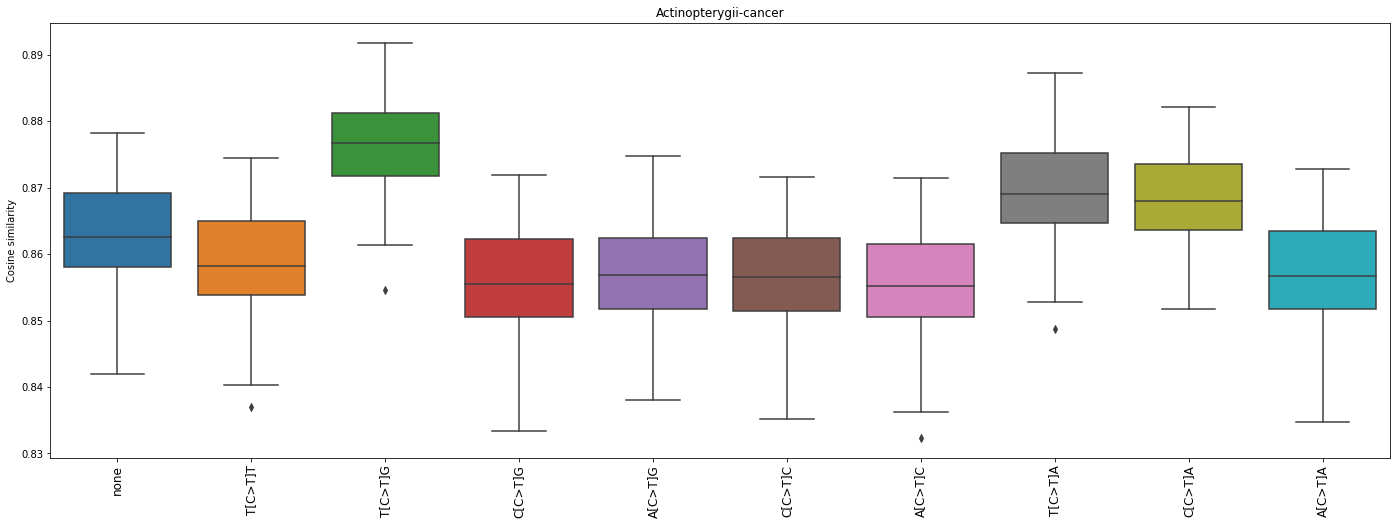

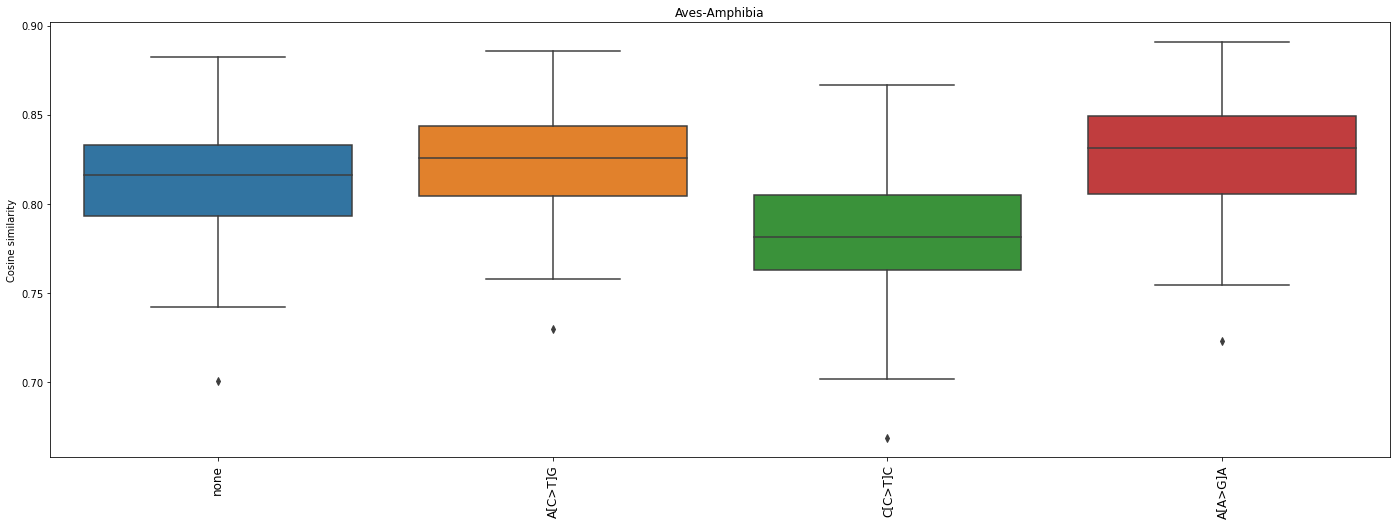

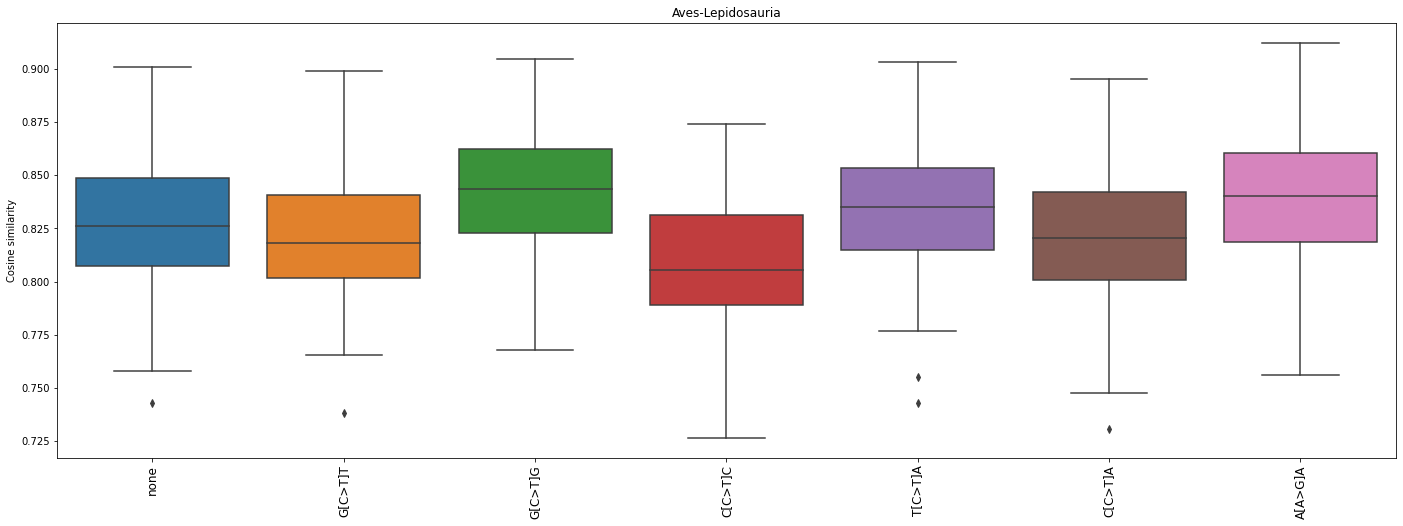

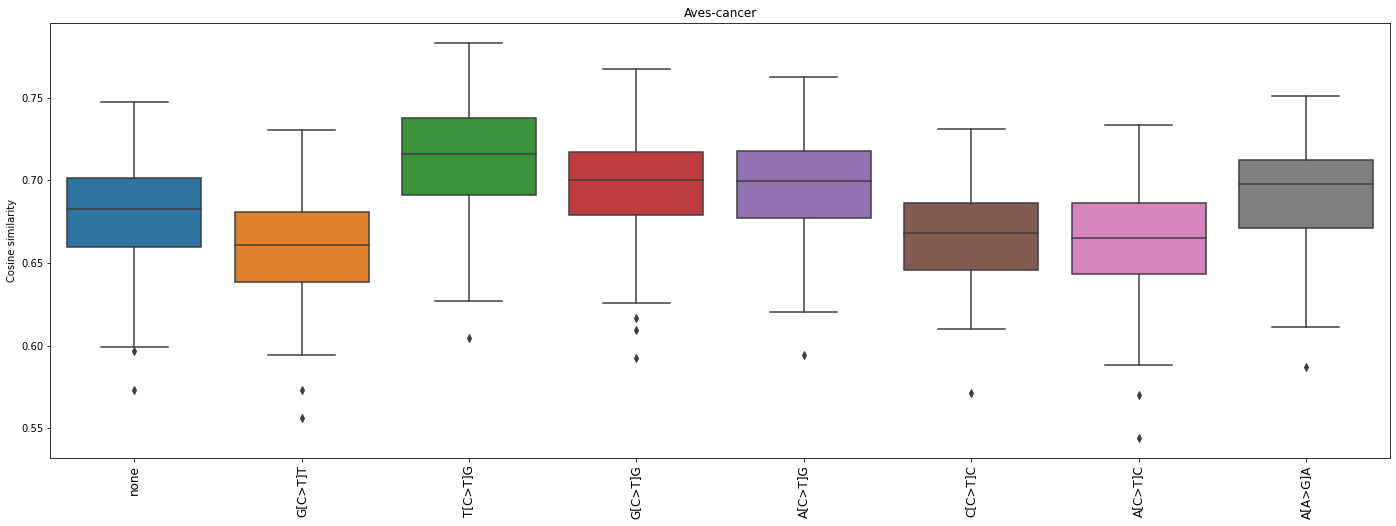

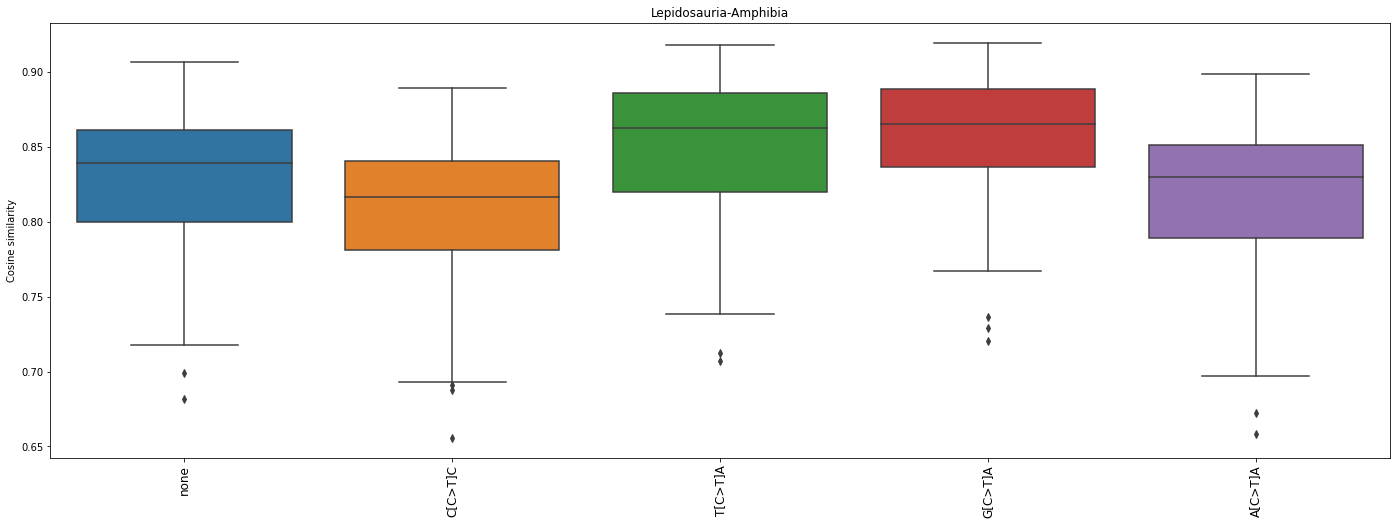

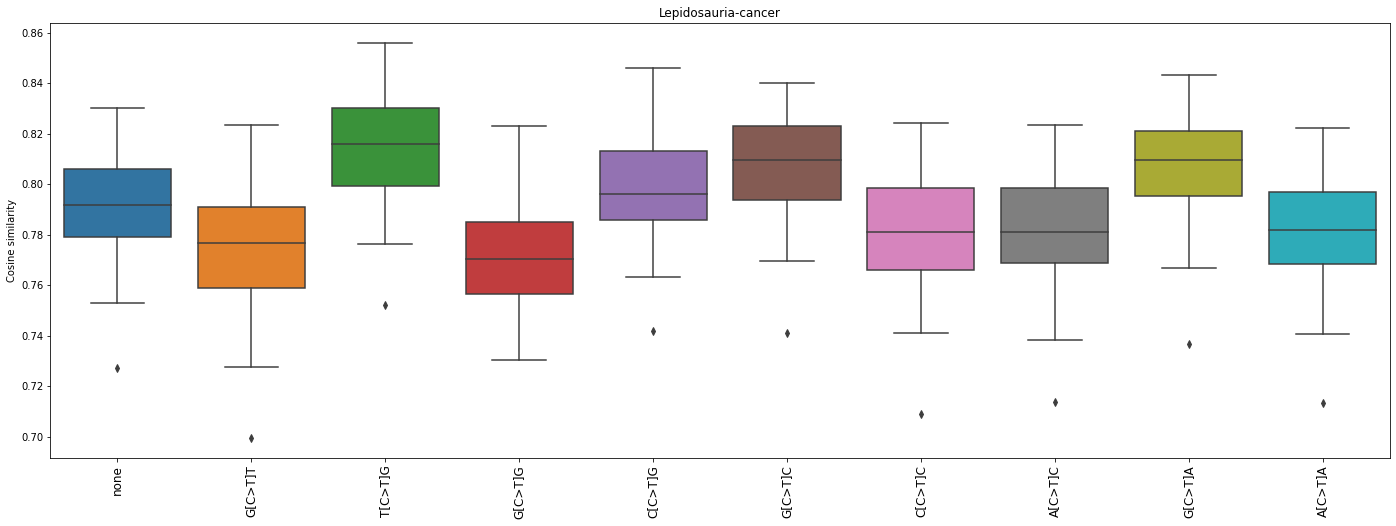

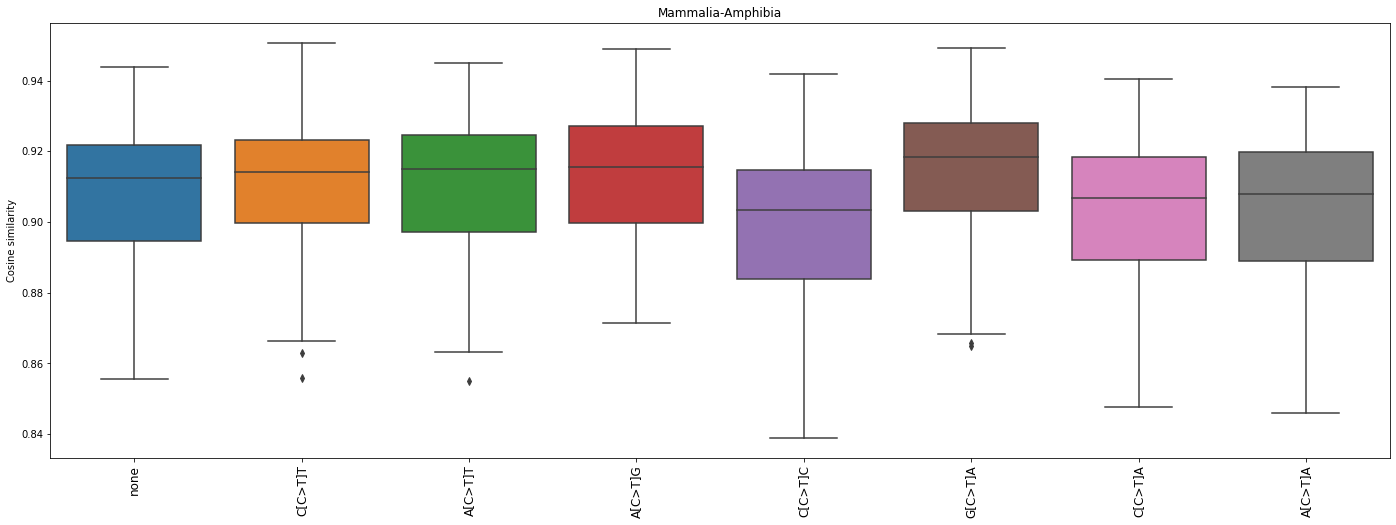

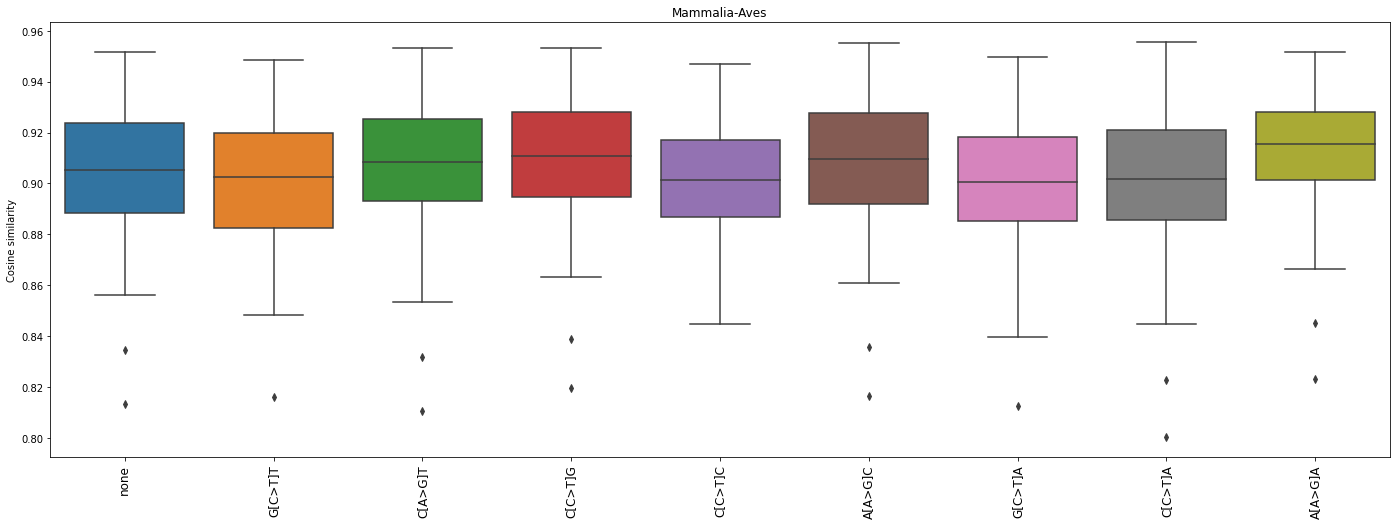

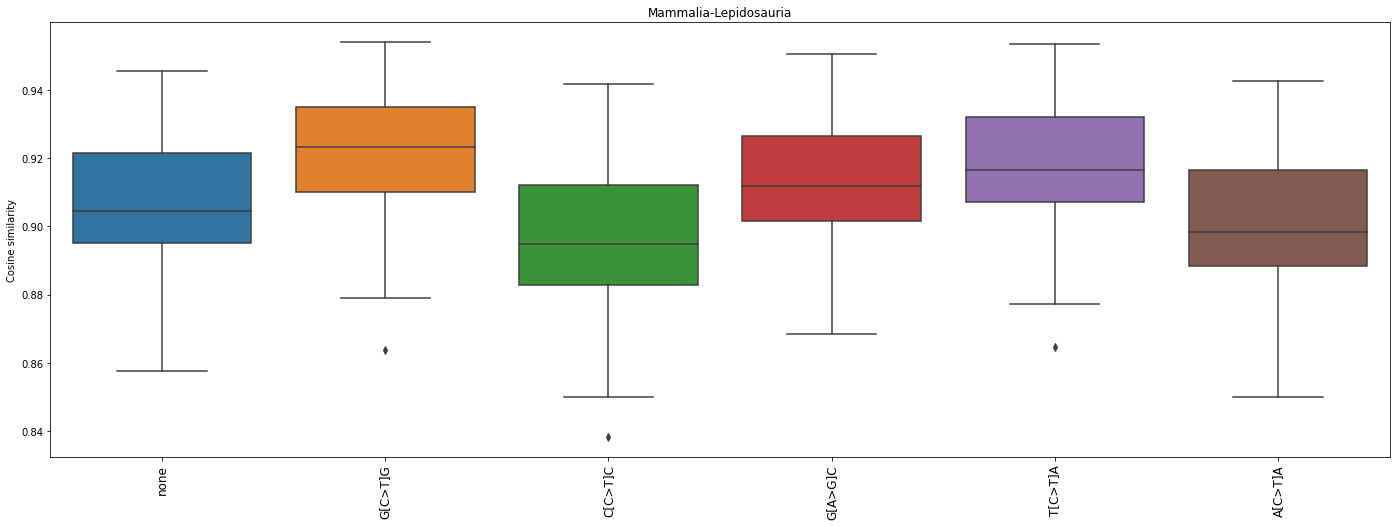

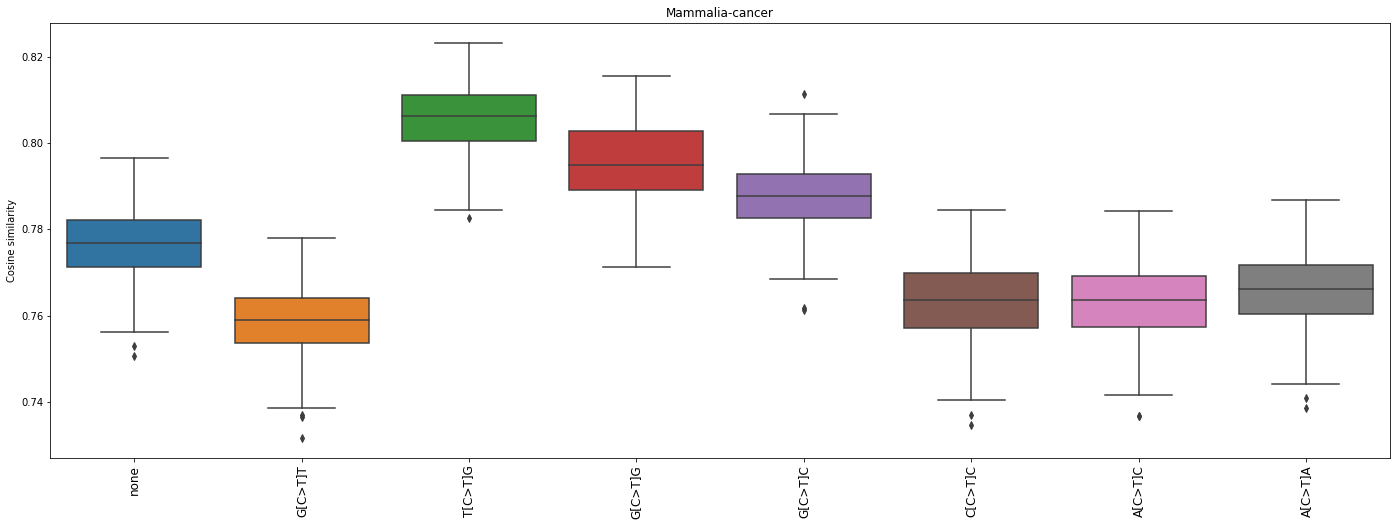

In [186]:
for lbl, gr in filtered.groupby(["cls1", "cls2"]):
    plt.figure(figsize=(24, 8))
    plt.title("-".join(lbl))
    ax = sns.boxplot(data=gr, x="DroppedSBS", y="CosSim")
    plt.xticks(rotation=90, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel("Cosine similarity")
    plt.show()

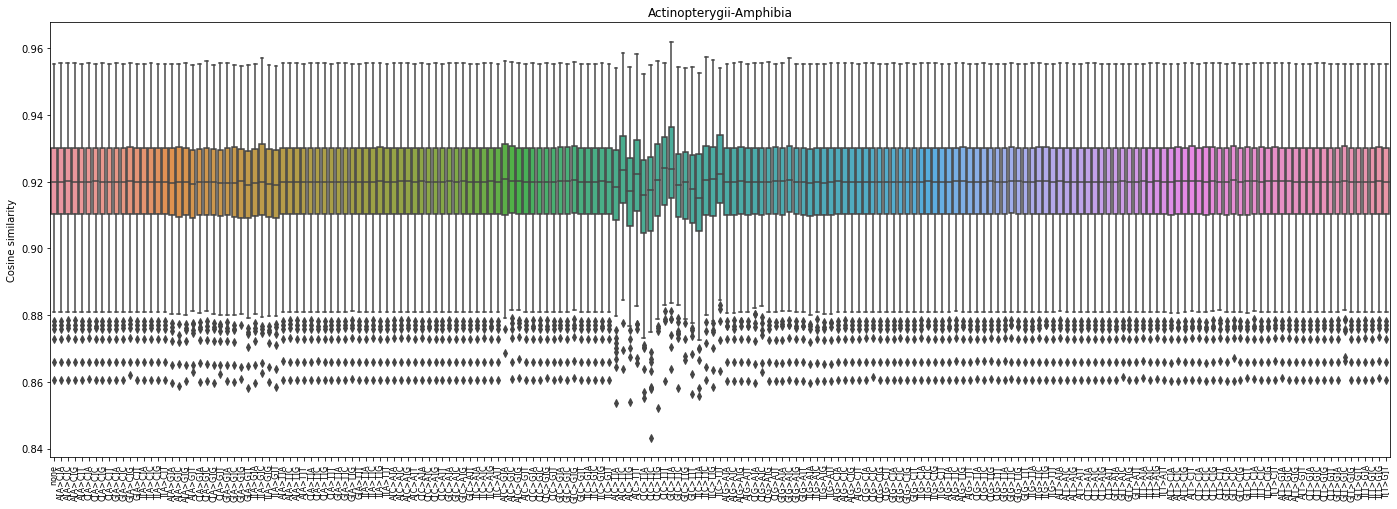

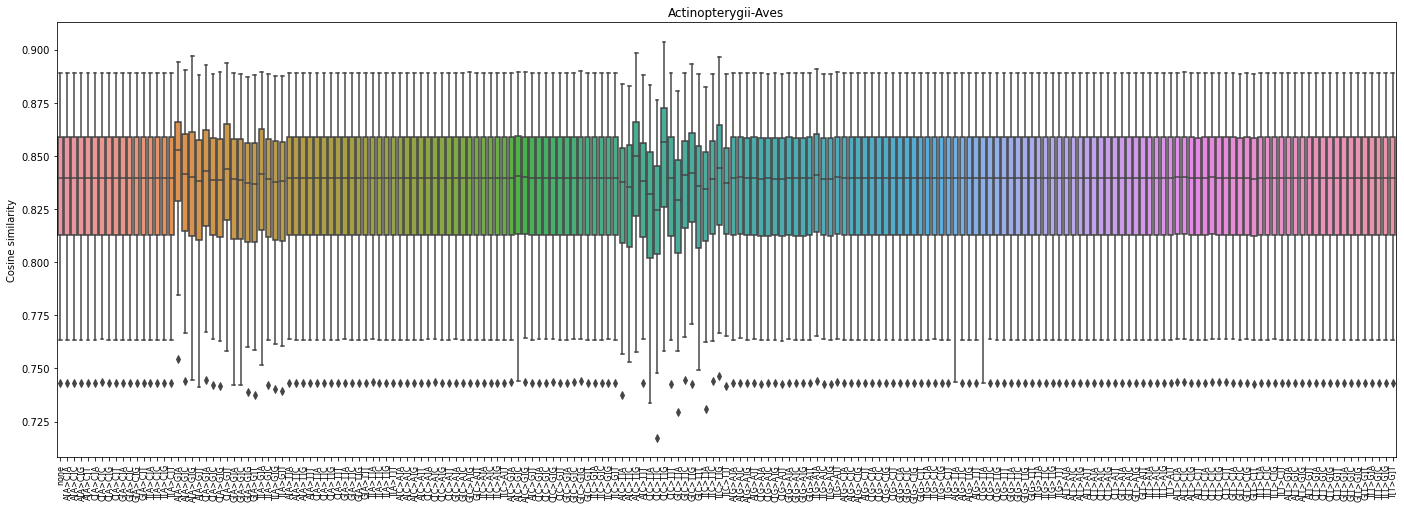

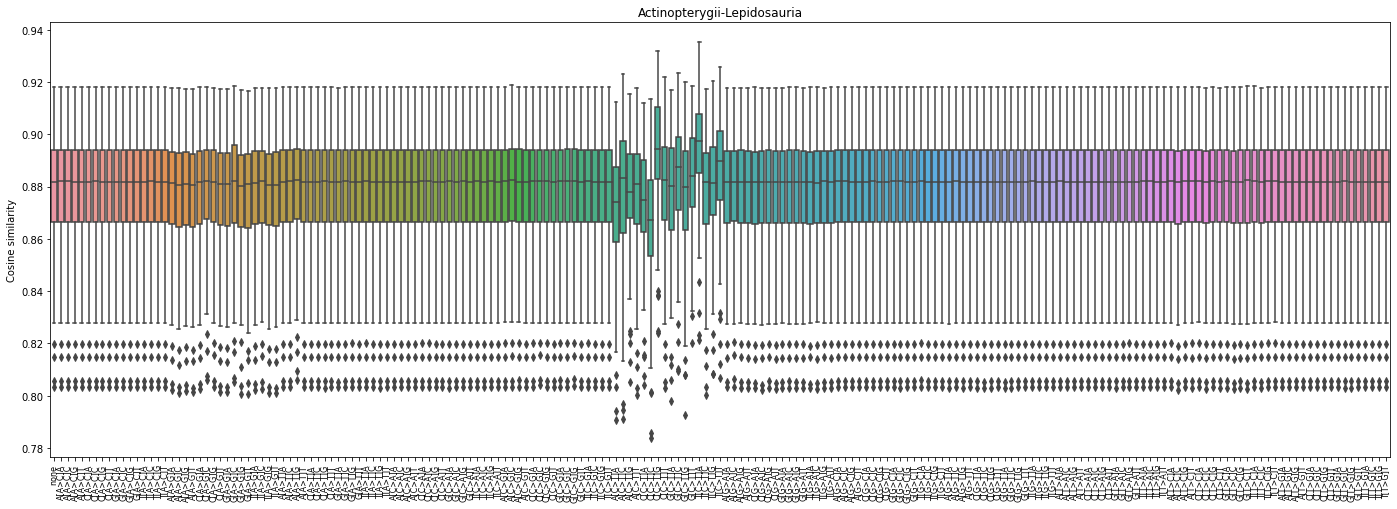

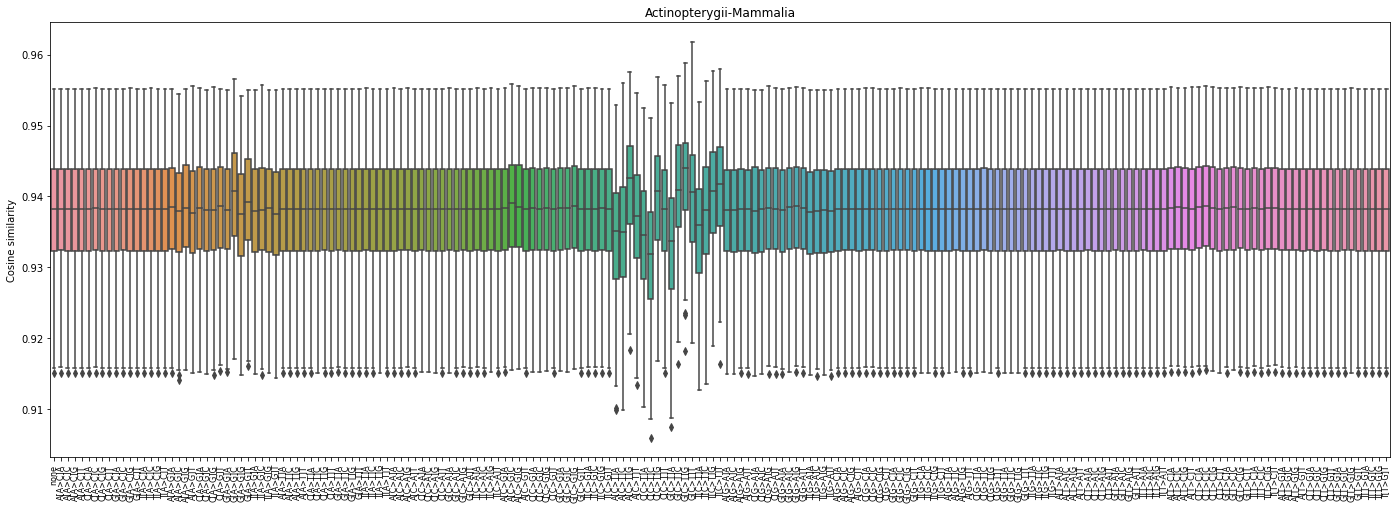

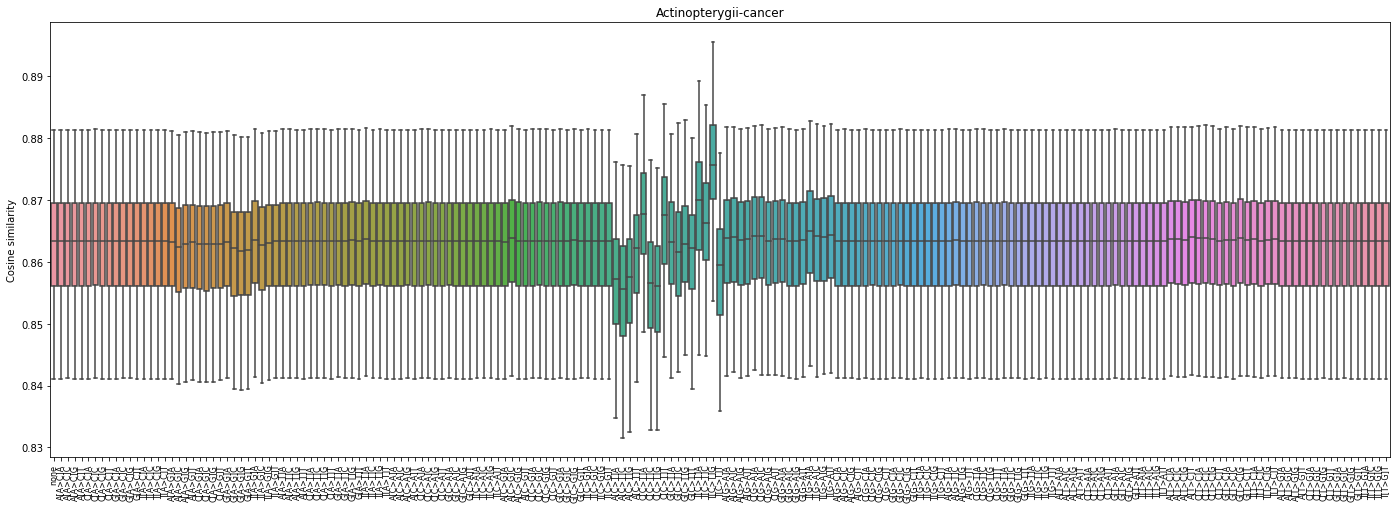

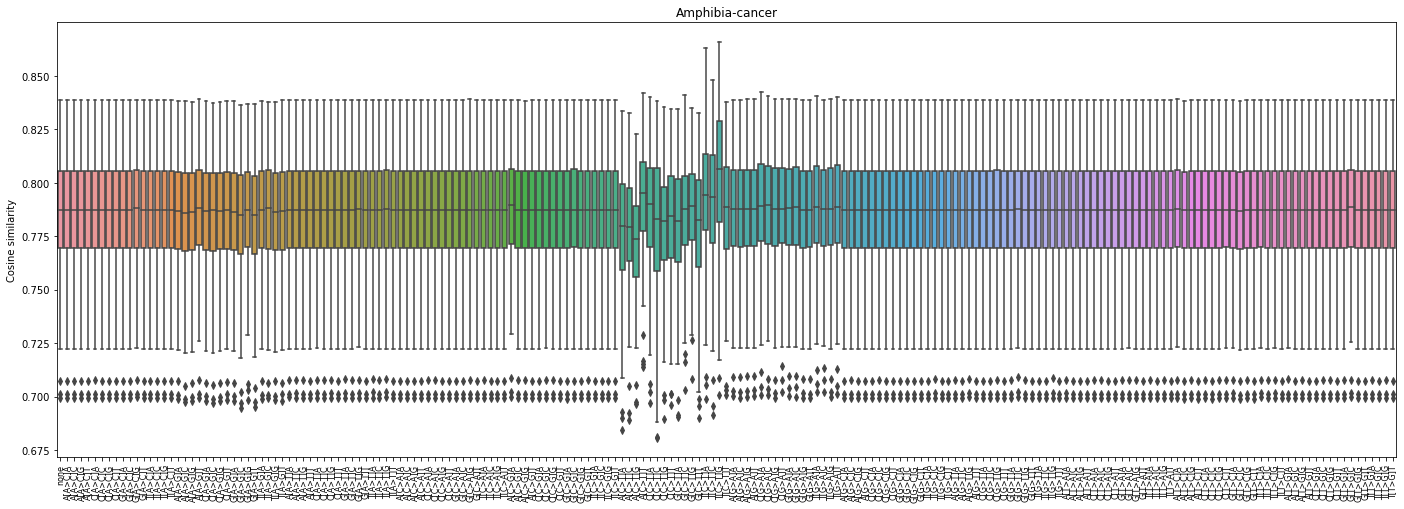

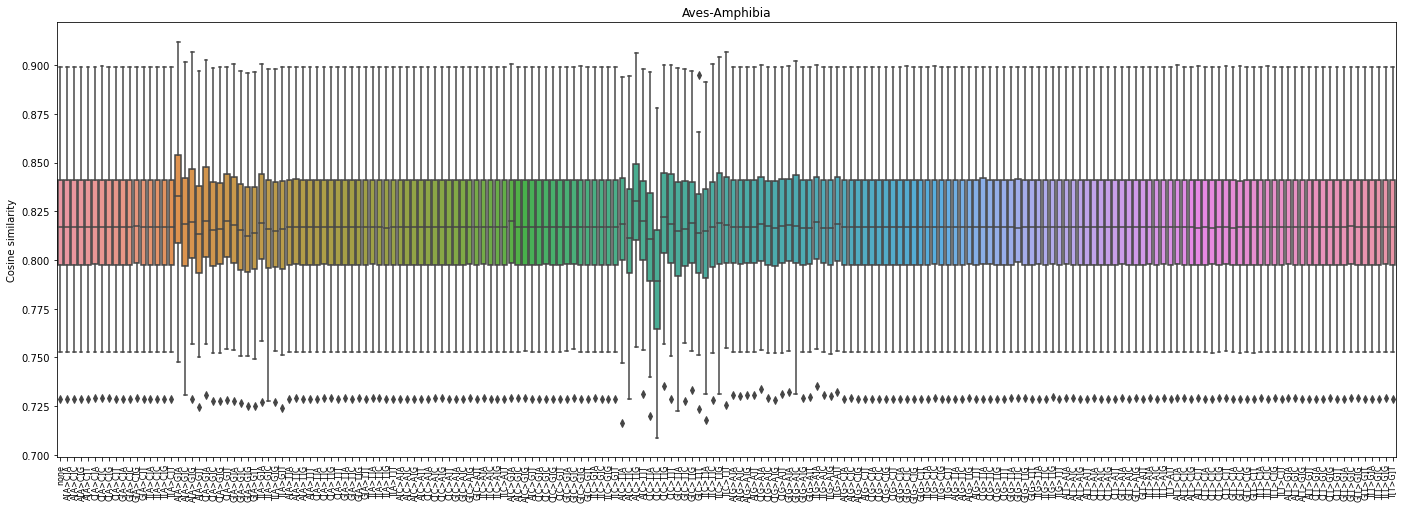

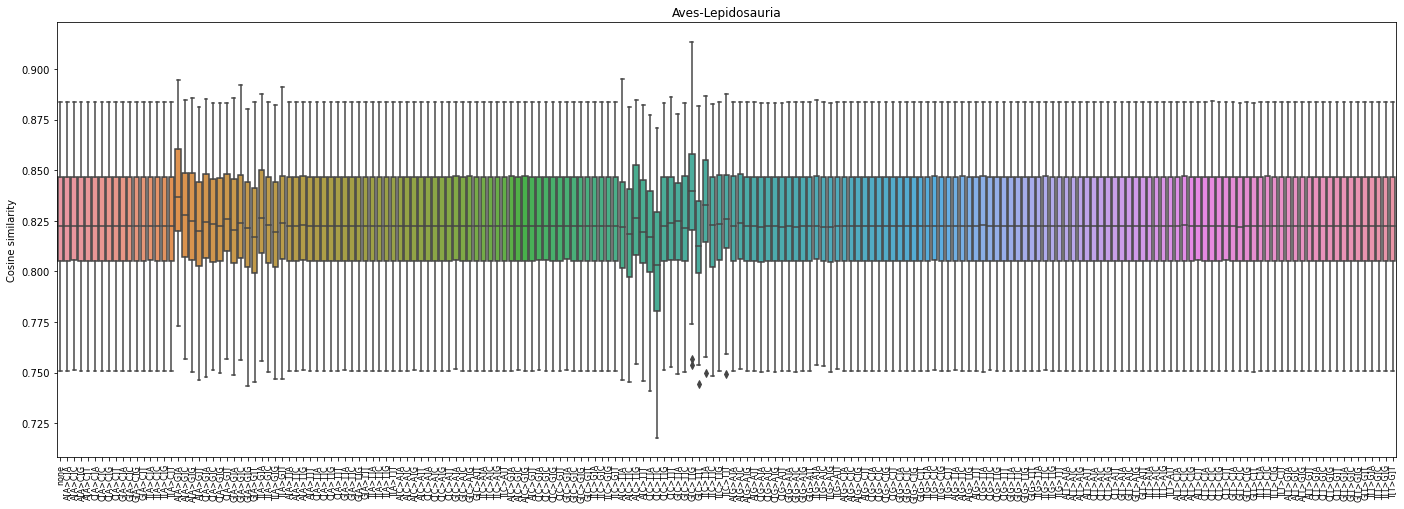

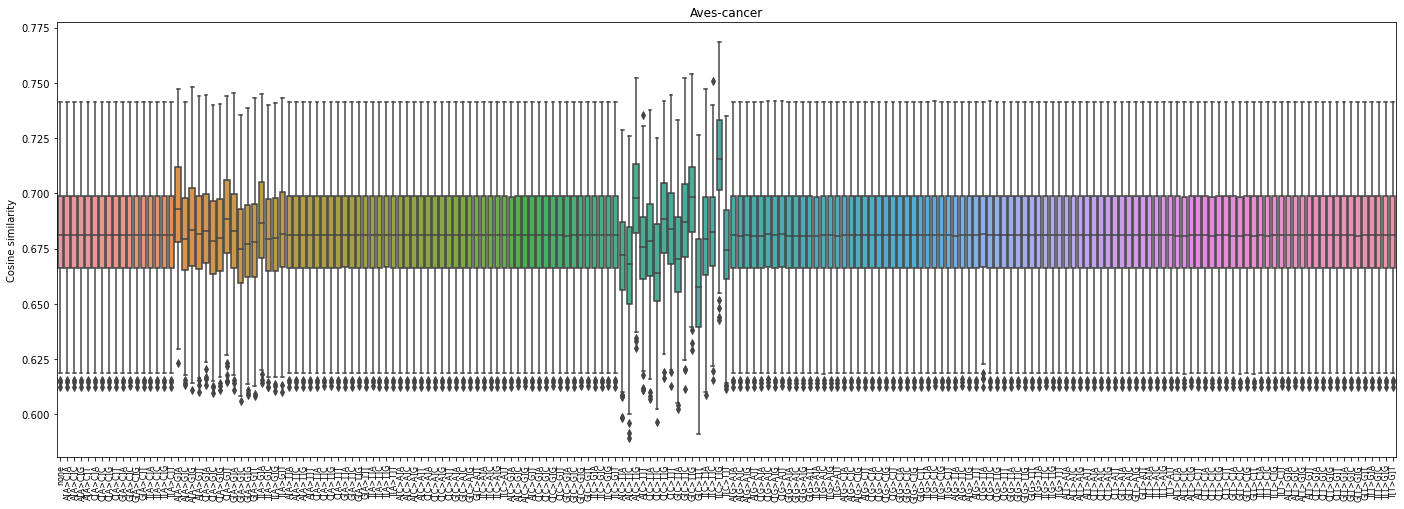

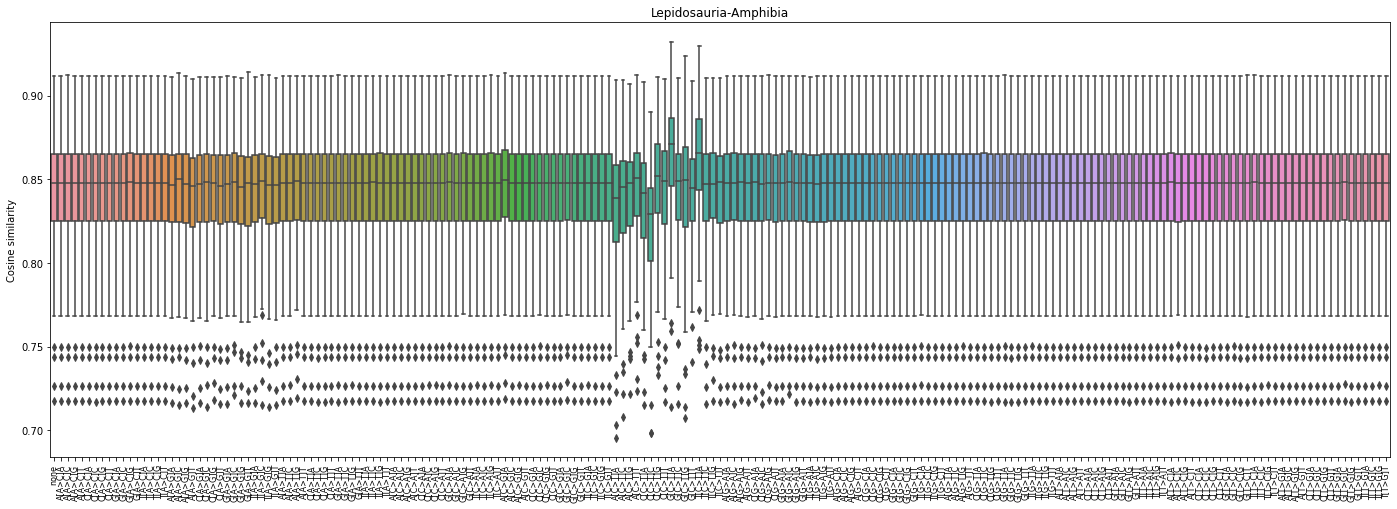

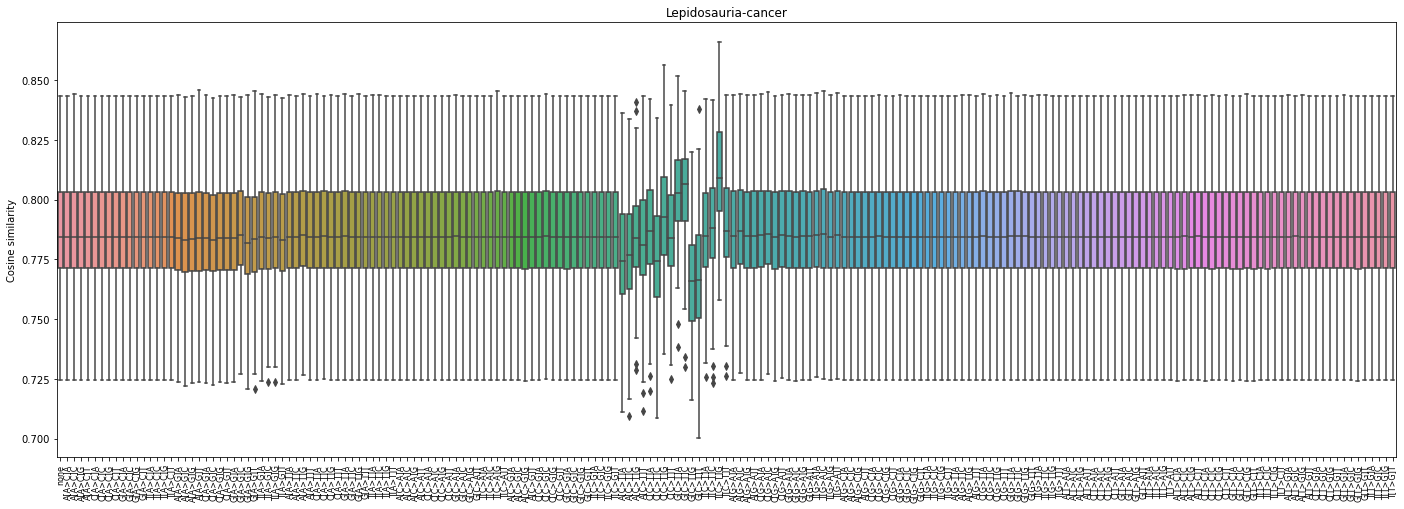

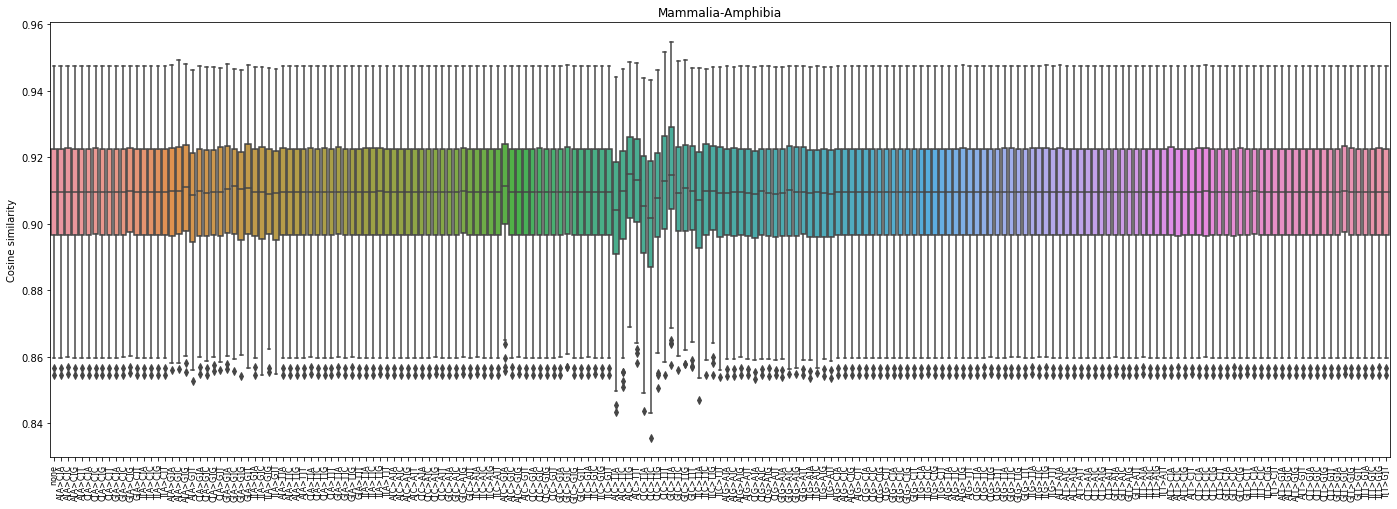

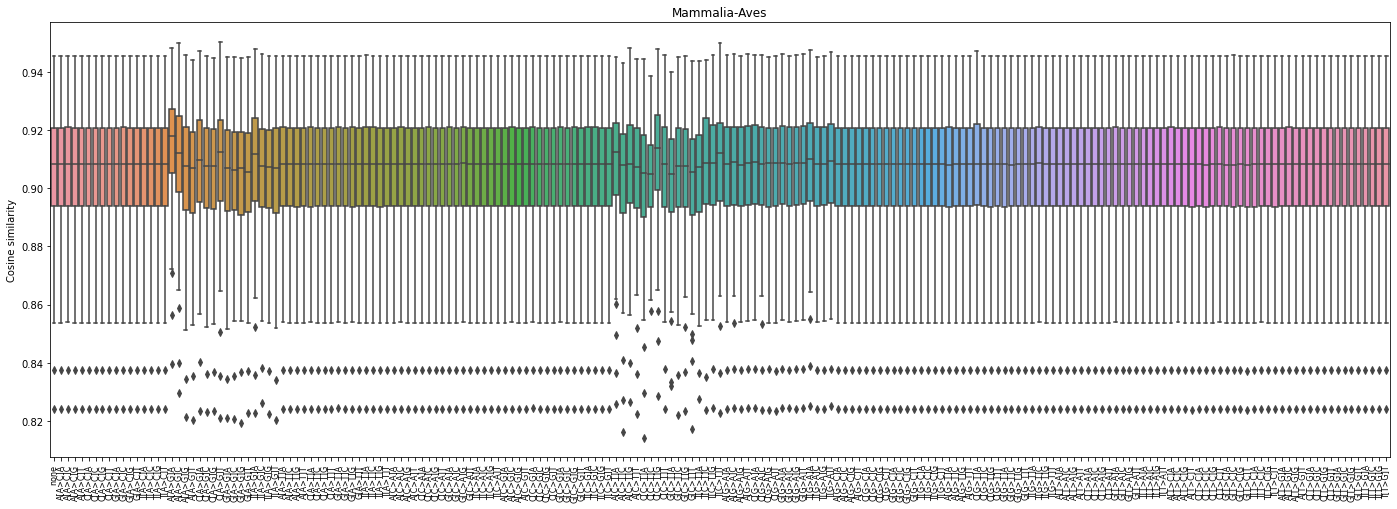

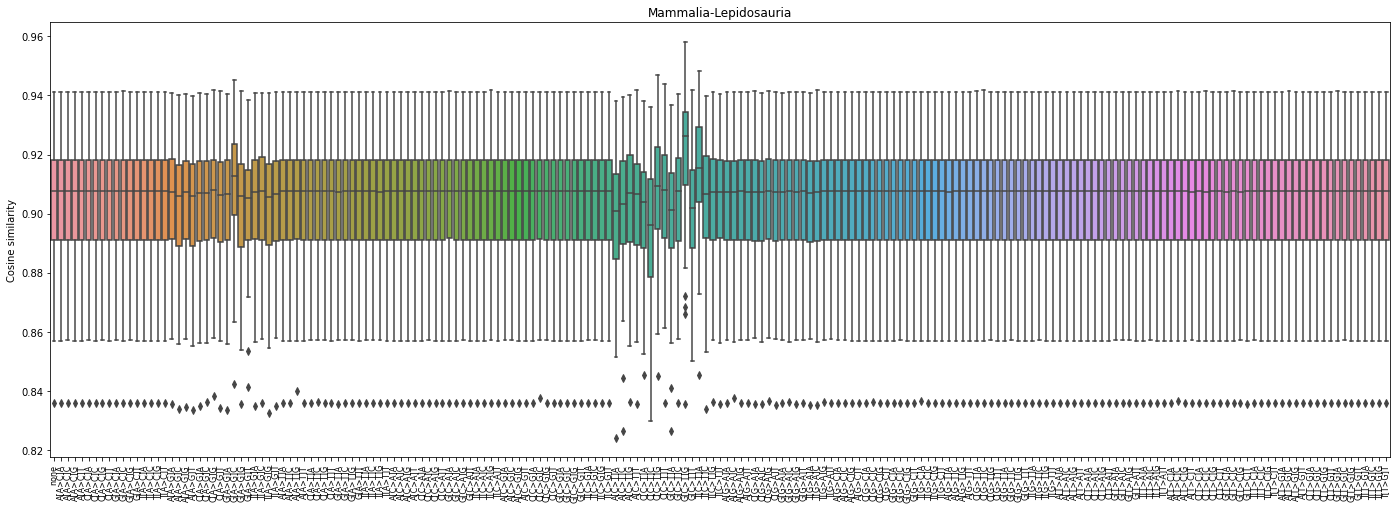

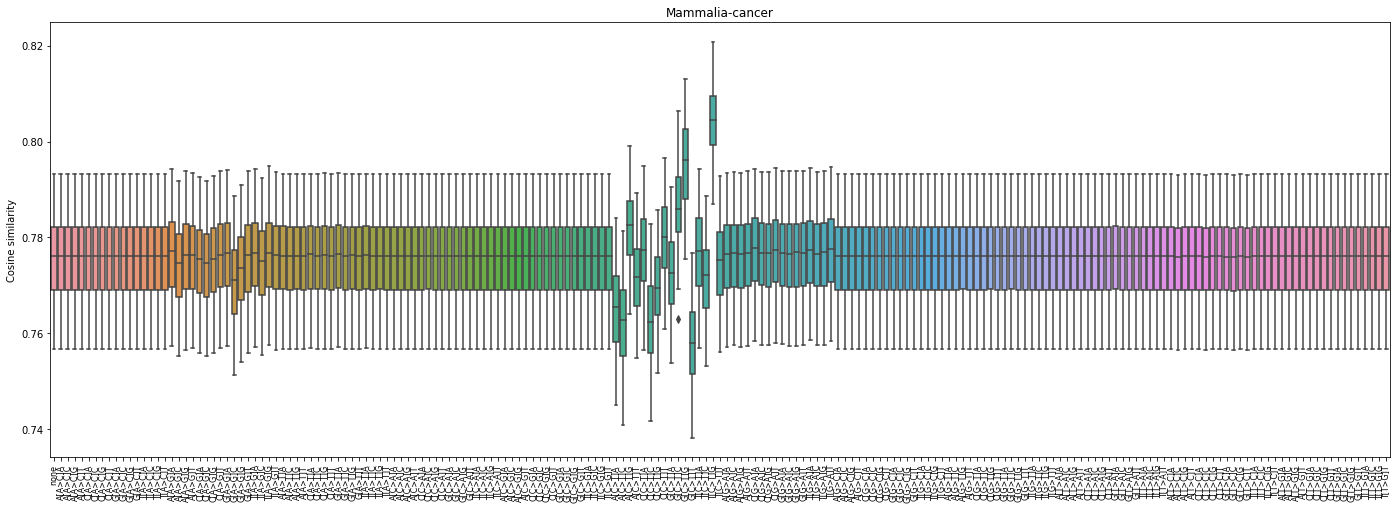

In [134]:
for lbl, gr in dif.groupby(["cls1", "cls2"]):
    plt.figure(figsize=(24, 8))
    plt.title("-".join(lbl))
    ax = sns.boxplot(data=gr, x="DroppedSBS", y="CosSim", order=["none"] + possible_sbs192)
    plt.xticks(rotation=90, fontsize=8)
    ax.set_xlabel("")
    ax.set_ylabel("Cosine similarity")
    plt.show()